# Lesson 7

## Resnet -> MNIST

### Data

In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_png/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/testing')]

Let's use an Image list getting them from our folder. The convert_mode is an argument sent to pilow (which is the library used to open images) so we have to use *L* as our convert mode since this are on a gray scale.

The items attribute will contain a list of filenames.

In [4]:
il = ImageList.from_folder(path, convert_mode='L')
il.items[0]

PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/9/48159.png')

We should use a binary color map due to our gray scale. This pice of code tells fastai we should display images in a gray scale.

In [5]:
defaults.cmap='binary'

In [6]:
il

ImageList (38471 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_png

As we can notice from above, our images are a rank 3 tensor of 1 x 28 x 28. This transformation is done since pytorch works a lot with rank 3 tensors. Let's see what an item looks like:

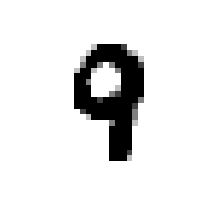

In [7]:
il[0].show()

Let's split this by training and validation sets.

In [8]:
sd = il.split_by_folder(train='training', valid='testing')

In [9]:
sd

ItemLists;

Train: ImageList (28471 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_png;

Test: None

In [10]:
(path/'training').ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/8')]

As we can see there we should label this images by their folder. Let's do so.

In [11]:
ll = sd.label_from_folder()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
4, 0, 1, 3, 6
  if getattr(ds, 'warn', False): warn(ds.warn)


In [12]:
ll

LabelLists;

Train: LabelList (28471 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /home/ubuntu/.fastai/data/mnist_png;

Valid: LabelList (4935 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /home/ubuntu/.fastai/data/mnist_png;

Test: None

In [13]:
x, y = ll.train[0]

9 torch.Size([1, 28, 28])


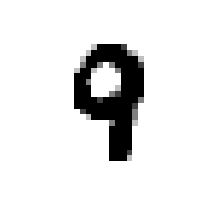

In [14]:
x.show()
print(y, x.shape)

Let's add transforms, however we aren't going to use the normal *get_trandforms* function since we don't really want to flip it or rotate it since that would change the meaning of the actual number, we will instead simply use some random padding. Which returns 2 transforms, the bit that does the crop and the bit that does the padding. The second array refers to the transformations for the validation set so no transforms for it.

In [15]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [16]:
ll = ll.transform(tfms)

In [17]:
bs = 128

So since we are not using imagnet_stats for normailzation it will grab a batch of data at random and use that to decide what normalization stats to use. This is a good idea if we are not using a pretrained model.

In [18]:
#not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [19]:
x,y = data.train_ds[0]

Let's see how the transforms look:

9


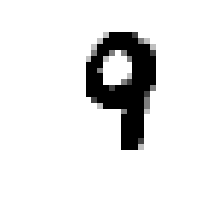

In [20]:
x.show()
print(y)

Plot multi will help us plot the result of calling some funciton in a grid.

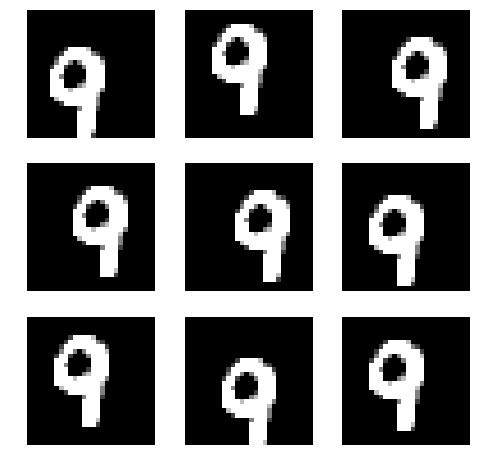

In [21]:
def _plot(i, j, ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8, 8))

Let's grab some batch form our data

In [22]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

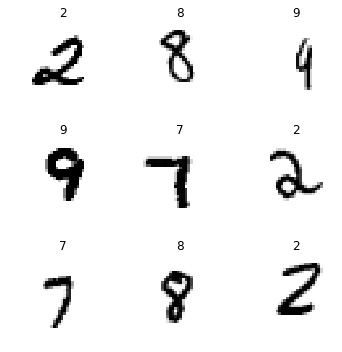

In [23]:
data.show_batch(rows=3, figsize=(5, 5))

### Basic CNN with batchnorm

#### Simple cnn

Let's create a simple convolution function that simplifies a bit our lives

In [36]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

Let's define a simple model. This model will have 5 combolutions using the conv(*input_chanels*, *output_chanels*). Now in our last convolution we pretty much end up with 10 chanels of size 1x1 so we flatten that out so it converts it from 10x1x1 to a vector of length 10.

In [37]:
model = nn.Sequential(
    conv(1, 8), #14
    nn.BatchNorm2d(8),
    nn.ReLU(),

    conv(8, 16), #7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    
    conv(16, 32), #4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    
    conv(32, 16), #2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    
    conv(16, 5), #1
    nn.BatchNorm2d(5),
    Flatten()
)

In [38]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [39]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [28]:
nn.CrossEntropyLoss??

In [29]:
#xb = xb.cuda() #use this in case we have a gpu

Let's test running a batch through our model to see we are getting the right output:

In [40]:
model(xb).shape

torch.Size([128, 5])

In [41]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


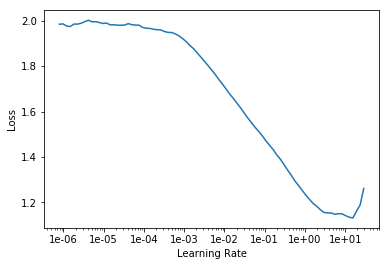

In [42]:
learn.recorder.plot()

Let's now train our model for a bit:

In [43]:
learn.fit_one_cycle(3, max_lr=0.1)

#### Refactor

Let's now refactor our code a bit:

Instead of doing:

        conv(16, 32), #4
        nn.BatchNorm2d(32),
        nn.ReLU(),
we can use *conv_layer* from fastai which returns the same + other extra options.

In [48]:
def conv2(ni, nf): return conv_layer(ni, nf, stride=2)

In [54]:
model = nn.Sequential(
    conv2(1, 8), #14
    conv2(8, 16), #7
    conv2(16, 32), #4
    conv2(32, 16), #2
    conv2(16, 5), #1
    Flatten()
)

In [55]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [56]:
learn.fit_one_cycle(10, max_lr=0.1)

#### Resnet

So how can we improve this? Well what we reallw want to do is create a deeper network. A very easy way of creating a deeper network would be that after a stride 2 convoluction add a stride 1 convolution. However there's a problem pointed out in the pape: *Deep Residual Learning for Image Recognition*. What this paper did is that it compared the results of using deeper networks and it showed that for some reason more layers isn't always the best thing to do to improve our accuracy. So they found that interesting and what they did is took the higher layer network and made a configuratin to it so it became mathematically at least as good as the lower layer network and here is how:

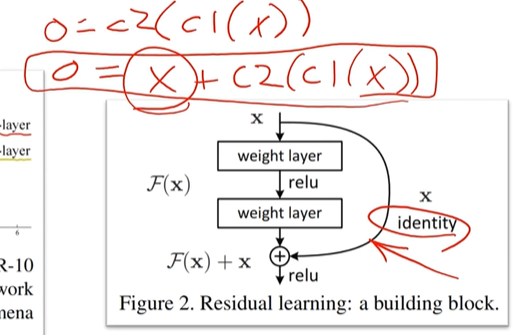

What they did was, every 2 convolutions, add together the input to those 2 convolutions with their result. So for 56 layers of convolutions worth of that the theory was that it would be as good as 20 regular convoluctions. The intuition is that we can always just set conv2(conv(1)) to a bunch of 0 weigths for evything except the first 20 layers because the input *x* can  go straight through. This is called an *identity* connection. This intuition won imagenet that year. Also it's important to note that this combination of convolutions is called a **resblock**.

A 56 layer nn without skip connections is really bumpy while one with skip connections is really smooth.
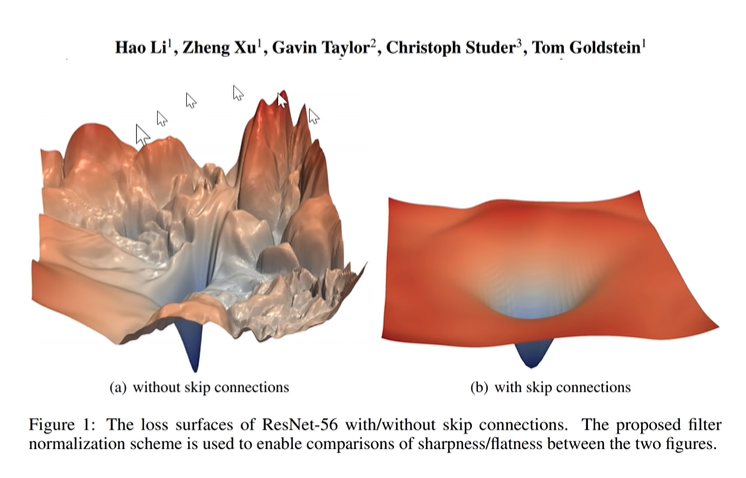

Let's do a resnet-ish optimization to our model

In [61]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().init()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
    
    def forward(self, x): return x + self.conv2(self.conv1(x))

fastai aready has one res_block funtion:

In [59]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [62]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
   
    conv2(8, 16),
    res_block(16),
    
    conv2(16, 32),
    res_block(32),
    
    conv2(32, 16),
    res_block(16),
    
    conv2(16, 5),
    Flatten()
)

Let's do a refactorization

In [65]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [67]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv_and_res(16, 5),
    Flatten()
)

In [69]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


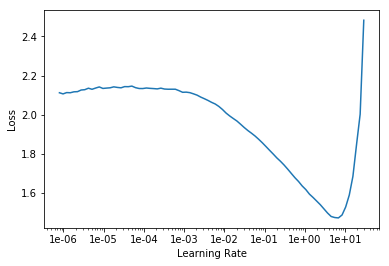

In [73]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [76]:
learn.fit_one_cycle(5, max_lr = 0.05)

As we can see we got very good results relatively quickly it's import ant to point out that **resnet** is a genuinely extremely useful network still today.

Also as we mentioned we actually used the *res_block* function from fastai. which looks this way:

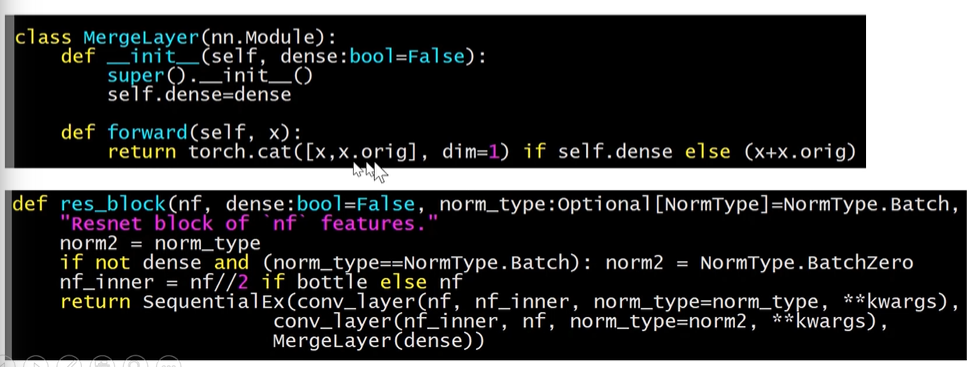

Here we can notice that we use a special type of sequential class created by fastai *SequentialEx* which we use in the res_block by returning 2 convolution layers and a MergeLayer. Which, if *dense* concatenates the original x with the result, otherwise it adds it up as our resntet does.


This dense parameter concatenates the original input with our current input. This is interesting, now it's called a denseblock which makes up densnets. So what basically happens is that we concatenate the chanels and the chanels get just bigger and bigger. Densenets, as we can imagine, are very memory intensive; there are ways to manage this such as regular convolutions that squeeze our hanels back down. However since they have very few parameters so for dealing with small datasets we should really experiment with densenets; they tend to work really well with small datasets. In fact they work very well for segmentation as well since we want to reconstruct the original image and when using a unet we can use it that way.

## Unet -> Camvid

In lesosn 3 we got very good result in our Unet learner. The main reason is that we where able to use transfered learinign from imagenet using resnet34.


Let's take a look into the unet:

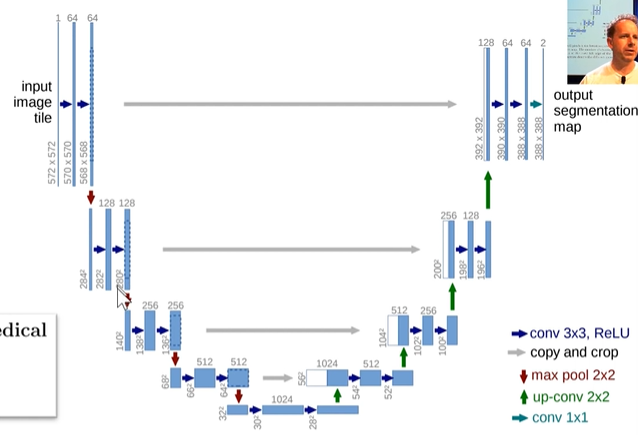

As we can see **from the original paper unet** in the first part we are doing 2 regular convolutions followed by stride 2 convolutions doubling the chanel size until we are at a 1024 28 by 28 chanels. This is the downsampling part. However fastai modified it to use a resnet 34 instead. By this point we want to end up with something that is the same size as our input. How do we do this? Currenly we only know how to use convolutions and strides to keep or reduce the size of our chanel but not increase it. The solution is a 1/2 stride convolution aka deconvolution or transposed convolution.

A stride convolution looks the following way:

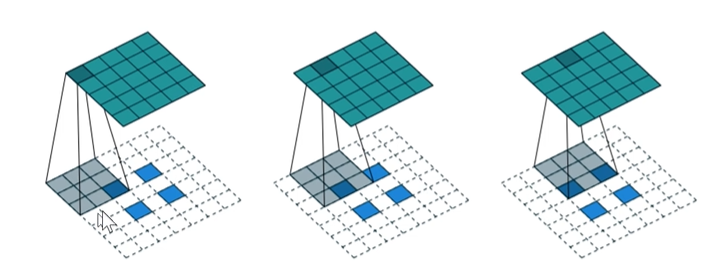

What happens is that we take our original input grid and add a pixel of padding bewteen each pixel, basically doubling the size of the image. We are going from a 2 by 2 to a 5 by 5 ouput. This is how we increase the resolution. However this is not that efficient since we are actually just adding 0s as our paddings. So a better thing to do is simply interpolate our image using the *nearest neighboor interpolation* before doing our deconvolution:

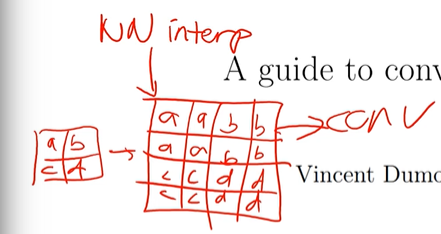



So basically the cool part about unets is that they use skip connections, aka identity connections to get a way better result, but rather than adding a skip connection skiping 1 or 2 convolutions they did it where the gray lines are in our *unet image* which makes total sense. And they didn't added them, they cocatenated them as we can see in the image which created *dense blocks* being unet a *dense network*.

Let's now take a look into the unet from fastai:

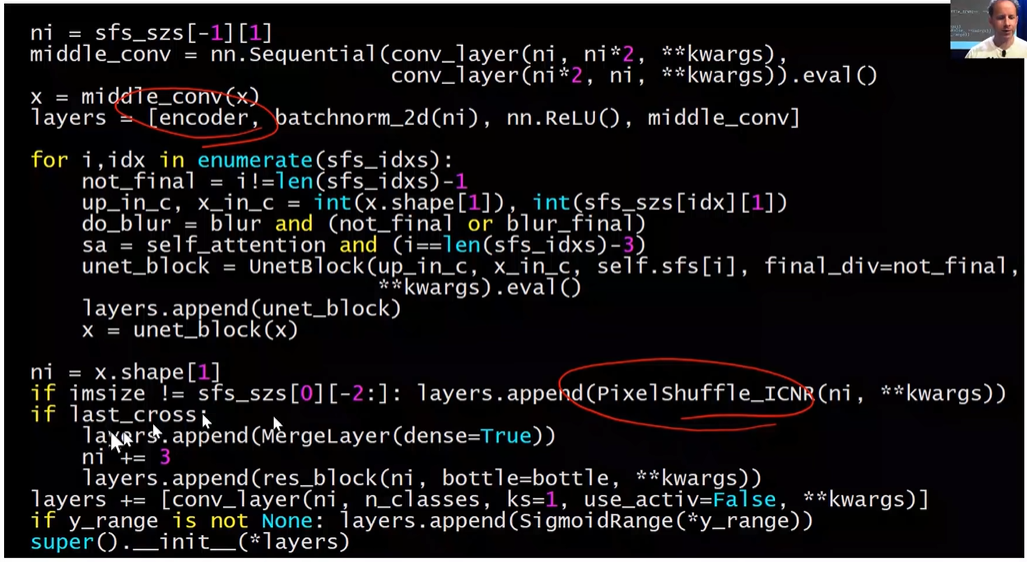

Here one key part is the **encoder** which refers to the first part from our unet for which we are using a resnet34 that we denote as our encoder, then we have a batchnor, then a Relu and then a middle_conv which is adding some basic convolutions at the middle part of the unet. 


One important thing to note is that we store the layer number where the convolutions with stride 2 happens and we loop trhorugh that and for each of those points we create a *unet_block* telling us how many upsampling chanels there are and how many cross connections (gray lines in our unet image). Some other tweaks this is doing, besides using resnet as our encoder, are upsampling using pixel shuffle with ICNR, and also passing the input pixels as well in the corss connections (at least for the first unet block).

So really the *unet_block* is doing all the job:

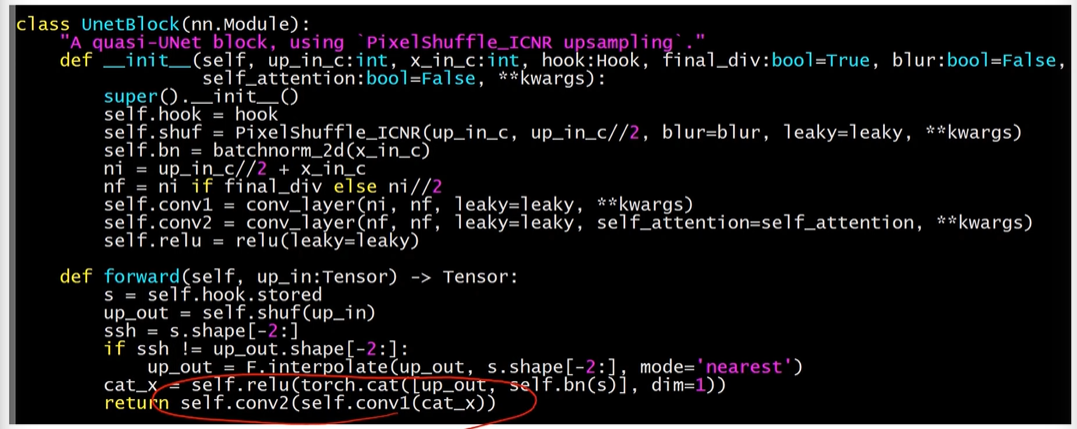


And what it's basically doign is storing all the activations in the downsamplings of the first part of our unet by unsing hooks and we take that stored value and concatenate it to the upsample convolution and then we do 2 convolutions.

## Image restoration -> PETS

We will be using our Pets dataset in which we will try to make bad quality turn to good quality images.

### Data

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

### Crappied data

In [3]:
from PIL import Image, ImageDraw, ImageFont

Basically what the crapiffy image is going to do is:
Take the image, reduce it's size to 96 using bilinear interpolation, draw a random number on it and then save the image with as JPG the quality of that number. We can instead look at the *crappify* library from fastai.

In [4]:
def crapify(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w, h = img.size
    q = random.randint(10, 70)
    ImageDraw.Draw(img).text((random.randint(0, w//2), random.randint(0, h//2)), str(q), fill=(255, 255, 255))
    img.save(dest, quality=q)

Run the below part if it's the first time running the notbeook 

In [5]:
# il = ImageList.from_folder(path_hr)
# parallel(crapify, il.items)

In [6]:
bs, size = 32, 128
arch = models.resnet34

### Pretrained generator

In [7]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [9]:
data_gen = get_data(bs, size)

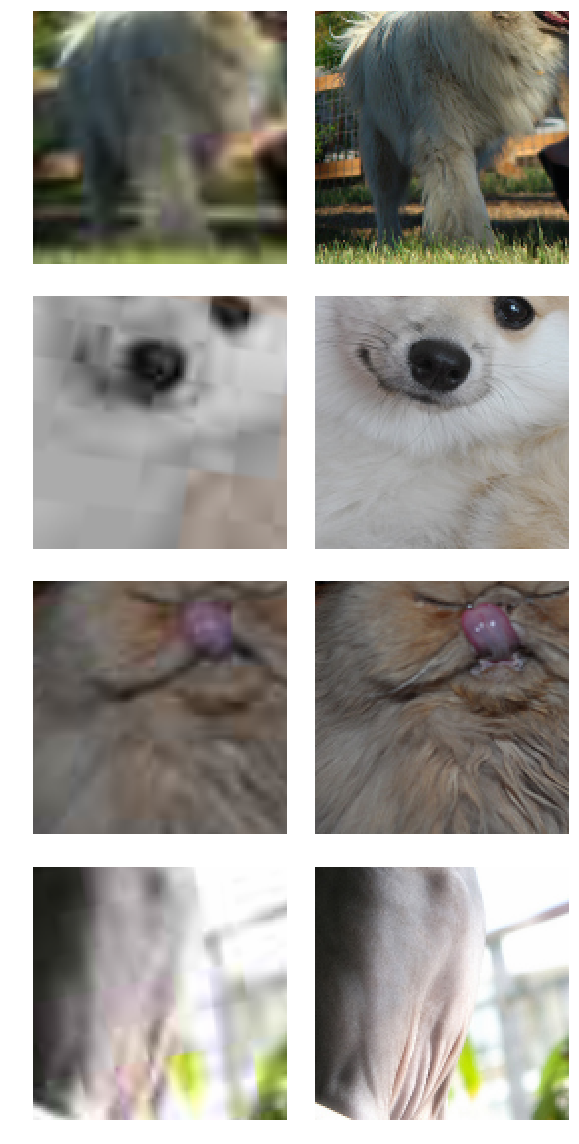

In [10]:
data_gen.show_batch(4)

In [11]:
wd = 1e-3

In [12]:
y_range = (-3., 3.)

For our loss we will use a MSELoss that flattens our data into a vector, we will be comparing each pixel from the 3 chanels of our image.

In [13]:
loss_gen = MSELossFlat()

So for our model we want a unet.

blur, norm_type and self_attention are very interesting but will be discussed in part 2 of the course.

In [14]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range, loss_func = loss_gen)

In [15]:
learn_gen = create_gen_learner()

In [17]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

Let's unfreeze the pretrained part which is the first part of the unet (the resnet 34) to continue training.

In [18]:
learn_gen.unfreeze()

In [19]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

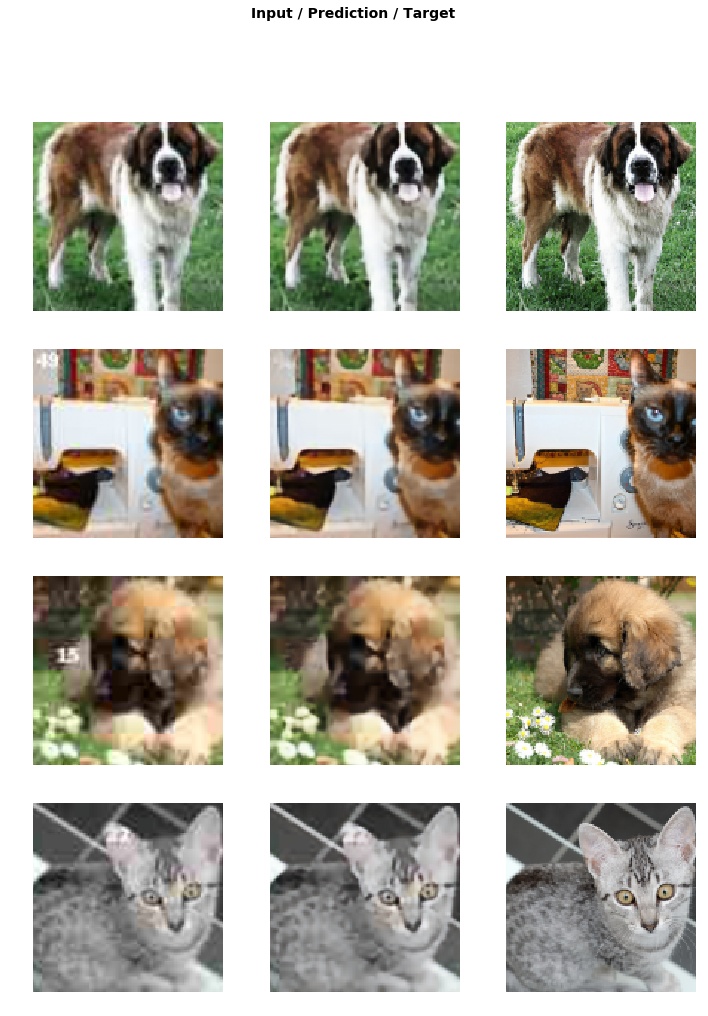

In [20]:
learn_gen.show_results(rows=4)

### GAN

As we can see below we got excelent results on removing the numbers but it's certainly not doing a good job on upsampling. If everything we wanted to do was watermark removal then we would pretty much be finished however we aren't. We want our pictures look better actually.


The reason we are not getting the results we want is because the loss function doesn't really describe what we want. Because actually the MSE of the results we have and the actual images is very small since most of the pictures are pretty much the right color. We are missing stuff like eyes or textures. We want a loss function that does something better than MSE of pixels. 


The way we do this is using a **Generative Adversarial Network** aka a **GAN**. What a GAN does is trying to solve this problem by using a loss function that actually calls another model. So what we actually do is reate anothe model called the Discriminator or Critic; this model will be a binary classification model that takes all the pairs of the generated image (result of our first model) and the real hd images and train this model to clasify which is which. Thi is, look at some picture and say wether is hd or not. If we had one of those we can fine-tune our image generator and rather than using pixel MSE as our loss, our new loss will be how good are we at fooling the critic.


Often what will happen after some iterations is that the generator will get good at fooling the critic so know we will stop training the generator and start training some more the Critic on the newly generated images (which are better at fooling the Critic). And this process will repeat on and on. This is a **GAN**. Pretraining the Generator and the Critic is **always** the best practice.


A lot of  online articles say that trianing a GAN is really hard but the pain of training them is actually at the start. Is the blind leading the blind. If we pretrain the Generator and Critic. The way we do this is pretrain them separately without using a GAN and then put them into the GAN.

In [23]:
learn_gen.save('gen-pre2')

#### Save generated files

To traing our Critic we have to save the generated images from our previous generator model

In [24]:
learn_gen.load('gen-pre2')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padd

In [26]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [27]:
path_gen.mkdir(exist_ok=True)

Let's create a funciton that takes a dataloader, takes all the file names in that dataloader, now let's go thorugh each batch in the dataloader and take a batch of predictions for that batch. Then we'll go though each of those predicitons and save them.

In [32]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i+=1

In [33]:
save_preds(data_gen.fix_dl)

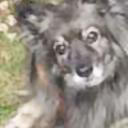

In [35]:
PIL.Image.open(path_gen.ls()[0])

#### Let's train a critic:

Let's get rid of the extra memory we are not currently ussing.

In [36]:
learn_gen = None
gc.collect()

802

In [42]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size = size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [43]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

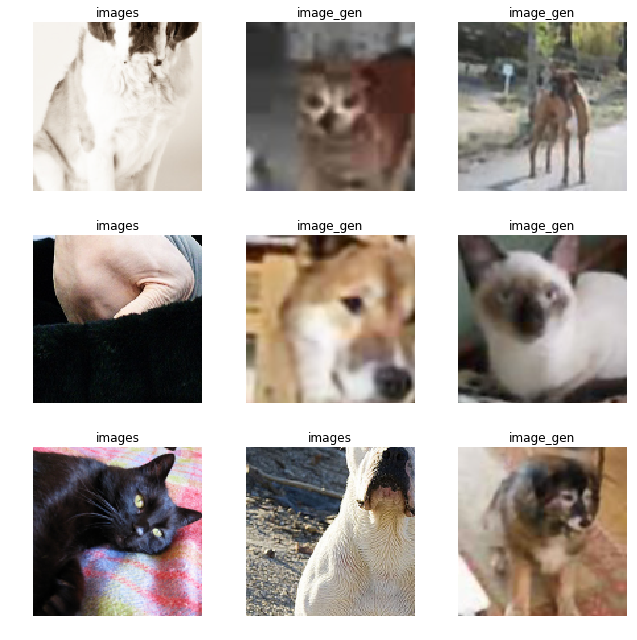

In [46]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

Let's use binary corssentropy as our loss:

In [54]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

One important thing to note from the critic we will be crating is that we are not using resnet as our architecture because basically when we are doing a GAN we should be careful that the generator and the critic can both push in the same direction and modify the weigths properly so we have to use something called spectrum normalization to make GANs work nowadays.


A gan critic uses a slightly different way of averaging the different parts of the image when it does the loss we will have to wrap our loss function with adaptive loss.

In [49]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [55]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [57]:
learn_critic.fit_one_cycle(3, 1e-3)

In [58]:
learn_critic.save('critic-pre2')

#### GAN

Let's finish up this GAN now that we've pretrained our generator and our critic.

In [ ]:
lear_crit=None
learn_gen=None
gc.collect()

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')
learn_gen = create_gen_learner().load('gen-pre2')

The ammount of time we spend on ping-pong ing between the generator and the critic and the learning rates we use are kind of in the fuzzy side so fastai provides us with a **GANLearner **which we pass it our generator and our critic and it will go ahead and do that for use. And when we go learn.fit() it will do that for us figuring out how much to train each.


An important thing to note is that the **weights** we are passing our GANLearner are used since what happens is that the critic is not only the loss function (if we only used the critic as our loss function our generator will get very good at generating images that fool our cirtic but aren't necceesaryly realistic looking images) so we actually add together the pixel loss and the critic loss. Thos 2 losses are in a different scale so we multiply the pixel loss by somethign around [50, 200].


Another thing to note is that for some reason GANs hate **momentum** when training them. That's why we have a 0 in our betas.

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1., 50.), show_img=False, switcher=cher=cher=cher=er=er=swithcer,
                                opt_func=partial(optim.Adam, betas=(0., 0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-4

Now, let's train our GAN.

An important thimg to note is that the loss for GANs is meaningless, we can't expect them to go down since as the generator get's better it's harder for the discriminator so we are getting in a sort of loop.

The only way to know how they are doing is to check the images from time to time. If we put show_img = True in our learner it will show a sample after every epoch.

In [ ]:
learn.fit(20, lr)

In [ ]:
learn.save('gan-1c')

Something important to note is that this gave better results that using MSE but it isn't that good, speccialy at details like eyes since our loss fucntion (Critic + MSE) doesn't know they are important as a resnet pretrained with imagenet stats does for instance.

### Perceptual Losses

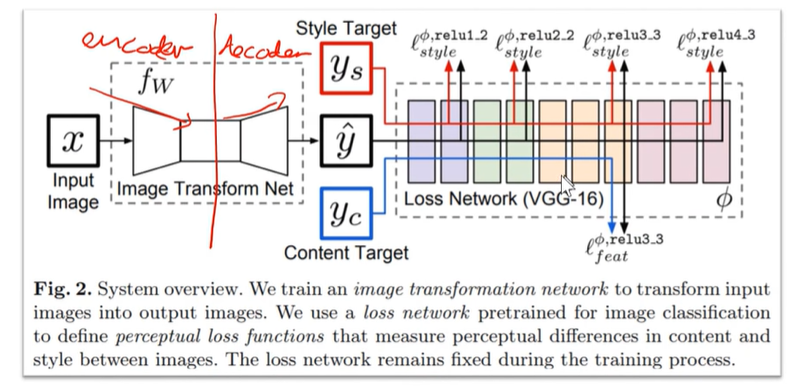

Something is that GANs doesn't always have the best results. So basically our problem is reduced in getting a better loss function which does a good job of saying "this is a good quality image and it looks like the thing it's ment to" without having to go through all the GAN trouble. Here's where **Perceptual Losses** aka **Feature Losses** come into use. It shares somethign with GANs which is, after we go through our generator and our loss function is comosed by taking the prediction and we put it through a pretrained imagnet network (such as Restnet or VGG) and so normally the output of that will tell us the classification of that and in the process of making such classification it goes through different layers and so what we do is ignore the final output of our model but we rather take something in the middle; we take the activations of somewhere in the middle; such activations may be a freature map of 256 chanels of 28 by 28 for instance; so this grid cells will kind of semantically say if in such part a certain feature was pressent. So now after doing that with our generated image we do the same but with the target, we pull the activations from the same layer and we do a MSE comparisson between both.


This implementation might actually help us fix the eyeball problem we had before for instance. This is why it's called **feature losses** so let's see how this look:

#### Data

In [3]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [5]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [8]:
il = ImageList.from_folder(path_hr)

Crappify like function but not that good:

In [9]:
def resize_one(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILLINEAR).convert('RGB')
    img.save(Dest, quality=60)

create smaller image sets the first time this nb is run

In [ ]:
# sets = [(path_lr, 96), (path_mr, 256)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

In [ ]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [ ]:
data = get_data(bs, size)

In [ ]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9, 9))

#### Feature loss

Let's try to create a loss funtion which does what Feature Losses does.

In [ ]:
t = data.valid_ds[0][1].data
t = torh.stack([t, t])

In [ ]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2))/(c*h*w)

In [ ]:
gram_matrix(t)

So let's create our base loss function which is basically how are we going to compare the pixels and the features and the choice is usually MSE or L1.

In [ ]:
base_loss = F.l1_loss

It's important to note that vgg has a *.features* part where it has the convolutional part of the vgg model. Because we don't actually need the head. We load that through the gpu and put it into eval mode because we are not trianing it. Also we will turn of *requires_grad* since we only need it for the inference part and not to calculate gradients.

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

So for the comparission point of our loss function we will have to get all the max pooling layers (because that's where the grid size changes) and take 1 layer before that because that's the layer before it changes. Which as we can see, are ReLUs.

In [ ]:
class FeatureLoss(nn.Module)

In [ ]:
blocks = [i-1 for i, o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in ]

So we wil need to create our FeatureLoss class that, when called:

- **init**: It should receibe a pretrained model *m_feat* and we will grab all of the layers from that network that we want the features of to create the losses and we should hook all those outputs to use them.

- **make_featuers**: It will receive an image, call the vgg model and store all the activations grabbing a copy of them.

- **forward**: It will call make features for both, our target and the output of our generator. Then we calculate the l1 loss between the pixels (beacuase we still want the pixel loss a bit) then we go through all the feature layers and get the l1loss on them and we finally sum them all up.

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5, 15, 2])

#### Train

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func = feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weigth)

gc.collect()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-3

Let's create a small funciton that does a fit one cycle, saves the model and then shows the results

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [ ]:
do_fit('1a', slice(lr*10))

As we can see we are already geting a pretty good output. Let's unfreeze and trian some more:

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('1-b', slice(1e-5, 1e-3))

Let's now use our technique to duplicate the image size and re-train our model.

In [ ]:
data = get_data(bs//2, size*2)
learn.data = data
learn.freeze()
gc.collect()

In [ ]:
do_fit('2a')

In [ ]:
learn.unfreeze()
do_fit('2b', slize(1e-6, 1e-4), pct_start=0.3)

After all we are already getting good results! We can now upsize to our medium res data and test on it.

## RNN (Recurrent Neural Networks) -> Human Numbers

Let's introduce a diagramatic method to explain RNNs.

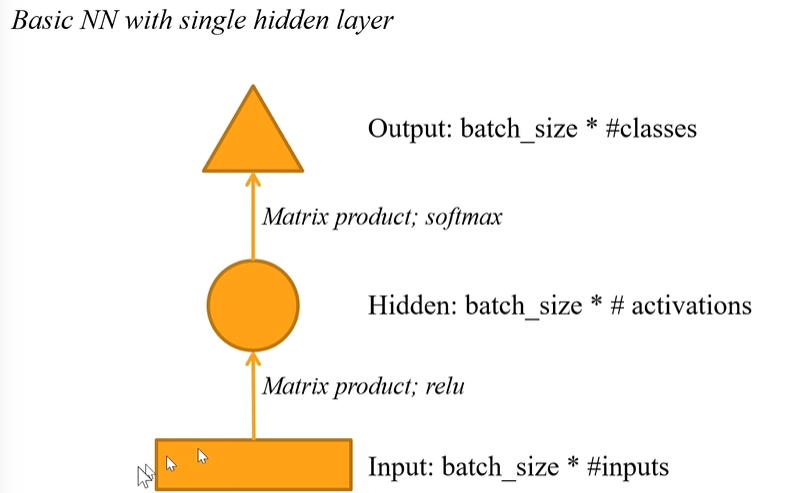

Here:

- yellow rectangle: means an input
- yellow arrow: means a matrix product (multiplying our input by weigths basically). It's basically a hiden leayer.
- yellow circle: means a hidden set of activations as a result from the yellow arrow operation.
- yellow trainlgle: means the oputput as a result from the previous yellow arrow operation.

Now let's take an example, let's say we have 3 words and we want to use the first 2 to predict the 3rd one.

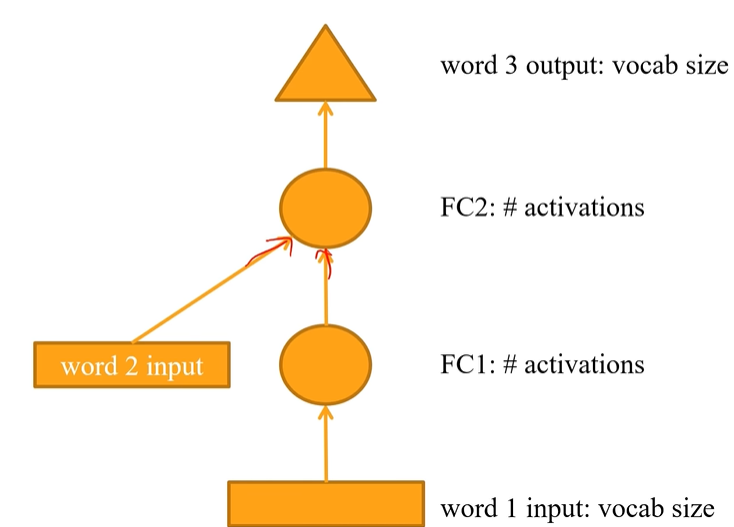

What we can do is:

- take word 1 as our input and chuck it thorugh an embedding.
- pass that through a matrix product and non-linearity.
- grab the 2nd word, put that through an embedding
- either add the result from the embedding of word 2 to the activation resutls from word 1 or concatenate them.
- finally do another matrix product and a non-linearity to get our output.

Let's go a bit further, what if we wanted to predict word 4 using the first 3 words?

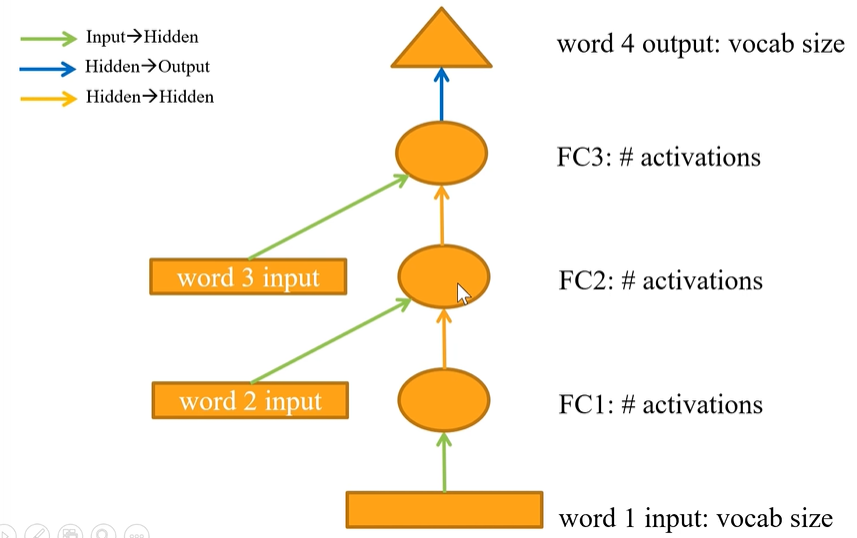

So as we can see it's just basically the same as with 2 words but now with a new word.

Here the important thing to notice is that:

- each time we go from rectangle to circle we are basically doing an embedding.
- each time we go from circle to circle we are basically doing a matrix product then a non linearity to say "we are at the next word".
- and the only time we go from circle to triangle we are doing a matric product then an special non linearity such as the softmax.

So it would make sense that every same-colored arrow use the same weight matrix since they are doing the same thing. Why would we have a different set of embeddings for each word or a different matrix to multiply by going from different hidden states to different hidden states.

### Human numbers example

Human numbers is basically a dataset that has all numbers from 1 to 999 written in english separated by a comma and we will create a language model that predicts the next word in this document.

#### Imports and basic setup

In [7]:
from fastai import *
from fastai.text import *

In [8]:
bs = 64

#### Data

In [9]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/human_numbers/valid.txt'),
 PosixPath('/home/ubuntu/.fastai/data/human_numbers/train.txt')]

In [10]:
def readnums(d): return [', '.join(o.strip() for o in open(path/d).readlines())]

Training will contain the first 8k numbers and validation will contain the last 2k numbers

In [11]:
train_txt = readnums('train.txt')
train_txt[0][:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [12]:
type(train_txt)

list

In [13]:
valid_txt = readnums('valid.txt')
valid_txt[0][-80:]

' nine thousand nine hundred ninety eight, nine thousand nine hundred ninety nine'

In [14]:
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

src = ItemLists(path=path, train=train, valid=valid)

In [15]:
src.label_for_lm()
data = src.databunch(bs=bs)

LabelLists;

Train: LabelList (1 items)
x: LMTextList
xxbos one , two , three , four , five , six , seven , eight , nine , ten , eleven , twelve , thirteen , fourteen , fifteen , sixteen , seventeen , eighteen , nineteen , twenty , twenty one , twenty two , twenty three , twenty four , twenty five , twenty six , twenty seven , twenty eight , twenty nine , thirty , thirty one , thirty two , thirty three , thirty four , thirty five , thirty six , thirty seven , thirty eight , thirty nine , forty , forty one , forty two , forty three , forty four , forty five , forty six , forty seven , forty eight , forty nine , fifty , fifty one , fifty two , fifty three , fifty four , fifty five , fifty six , fifty seven , fifty eight , fifty nine , sixty , sixty one , sixty two , sixty three , sixty four , sixty five , sixty six , sixty seven , sixty eight , sixty nine , seventy , seventy one , seventy two , seventy three , seventy four , seventy five , seventy six , seventy seven , seventy eight , se

In [16]:
src.databunch??

In [18]:
src.x._bunch.create??

In [49]:
src.label_for_lm??

We only have one documento so *train[0]* is such document. As we may now xxbos is a special fastai token meaning start of document (begining of stream)

In [13]:
train[0].text[:80]

'xxbos one , two , three , four , five , six , seven , eight , nine , ten , eleve'

The validation set contains 13k tokens, so 13k words or punctuation marks (everything separated by space is a different token)

In [14]:
len(data.valid_ds[0][0].data)

13017

The batch size we used is 64 and then by default it uses something called **bppt** of 70 which is *back prop though time* and that's the sequence length. So for each of our 64 document segments we split them into lists of 70 words that we look up at one time.

So what we do is, for our validation set for instance, grab our 13k tokens and then we split it in 64 roughly equal sized segments and then for each of those we split those into pices of length 70.

In [17]:
data.bptt, len(data.valid_dl) #dl is our data loader

(70, 3)

So there's about 3 batches in total:

In [16]:
len(data.valid_ds[0][0].data)/70/64

2.905580357142857

In [18]:
it = iter(data.valid_dl)
x1, y1 = next(it)
x2, y2 = next(it)
x3, y3 = next(it)
it.close()

In [20]:
x1.numel() + x2.numel() + x3.numel()

13440

In [22]:
x1.shape, y1.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [23]:
x2.shape, y2.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

Let's have a look at the first batch of x and y

In [33]:
x1[0]

tensor([ 2, 19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19,
        11, 16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,
         9, 19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9, 19, 11, 32,  9, 19,
        11, 33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19])

In [34]:
y1[0]

tensor([19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19, 11,
        16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,  9,
        19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9, 19, 11, 32,  9, 19, 11,
        33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19, 11])

Let's grab the vocab from our validation dataset:

In [27]:
v = data.valid_ds.vocab

In [31]:
v.textify(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight'

In [32]:
v.textify(y1[0])

'eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand'

In [37]:
data.show_batch(ds_type = DatasetType.Valid)

#### Single fully connected model

Let's now work with 3 words per sample per batch

In [56]:
data = src.databunch(bs=bs, bptt=3)

In [50]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [51]:
nv = len(v.itos); nv

40

In [52]:
nh=64

In [53]:
def loss4(input, target): return F.cross_entropy(input, target[:,-1])
def acc4(input, target): return accuracy(input, target[:, -1])

So let's simply make our model where we will basically implement  the following model:
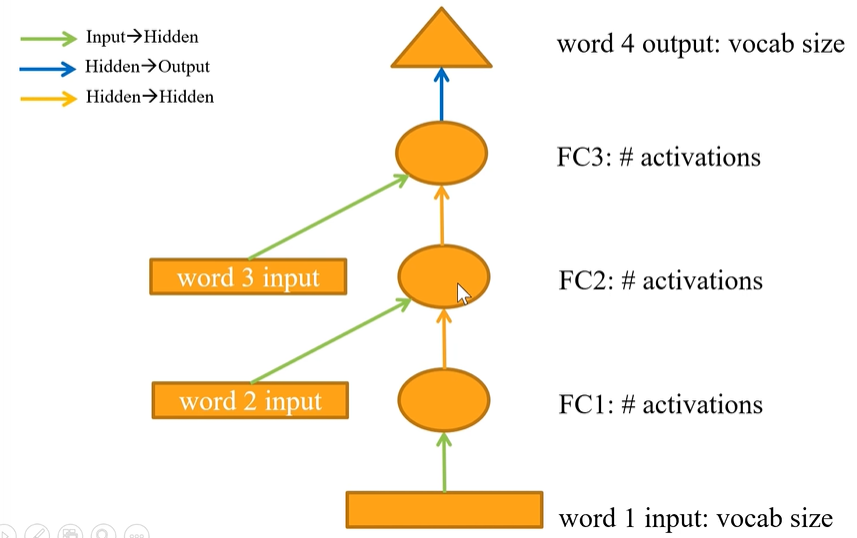

In [54]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh) # green arrow
        self.h_h = nn.Linear(nh, nh) # yellow arrow
        self.h_o = nn.Linear(nh, nv) # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:, 0]))))
        if x.shape[1] > 1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1] > 2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

Now let's re-write our **RNN** from the above code using a for loop as shown here:
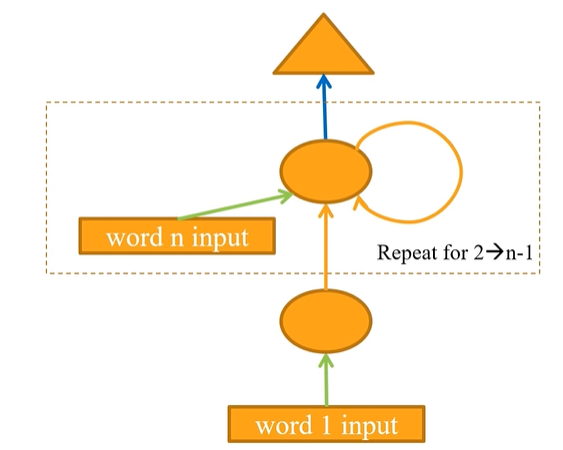

In [55]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh) # green arrow
        self.h_h = nn.Linear(nh, nh) # yellow arrow
        self.h_o = nn.Linear(nh, nv) # blue arrow
        self.bn = nn.BatchNorm1d(nh)
    
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

Something important to note is that now we can change our bptt to any arbitrary number and the Model1 will still work.

Also, by now our loss function is actually only computing the loss of the prediction from the n words. However we might algo wan't to calculate the loss for every i, i+1 word of our n words using the first i words to predict the i+1 and not only the n words to predict the n+1.

In orther to do the above step we have to change our architecture so that we don't only have 1 triangle at the end of the loop but rather inside the loop:

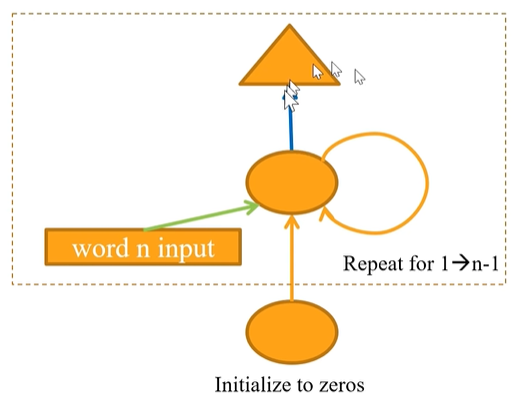

so we will predict after every loop.

In [57]:
data = src.databunch(bs=bs, bptt = 20)

In [59]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [74]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh) # green arrow
        self.h_h = nn.Linear(nh, nh) # yellow arrow
        self.h_o = nn.Linear(nh, nv) # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.h_o(self.bn(h)))
        return torch.stack(res, dim=1)

In [75]:
learn = Learner(data, Model2(), metrics=accuracy)

In [76]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.1)

We should note that after running this learner we will have a lower accuracy than using Model1 and the reson is that we are actually trying to make predictions after i words from 1 to n rather thatn only after n words as the Model1 was doing.

The key problem here is that we reset our h to zeroes everytime we start another bppt sequence, but let's not do that since every batch connects to the prevoius batch. This will be done by moving the creationg of h to the constructor.

In [93]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs, nh)
        
    def forward(self, x):
        res = []
        h = self.h
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.bn(h))
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res

In [94]:
learn = Learner(data, Model3(), metrics=accuracy)

In [95]:
learn.fit_one_cycle(20, 3e-3)

What we could do tho is, at the end of every loop not only spit out an output but also spit out into another rnn:

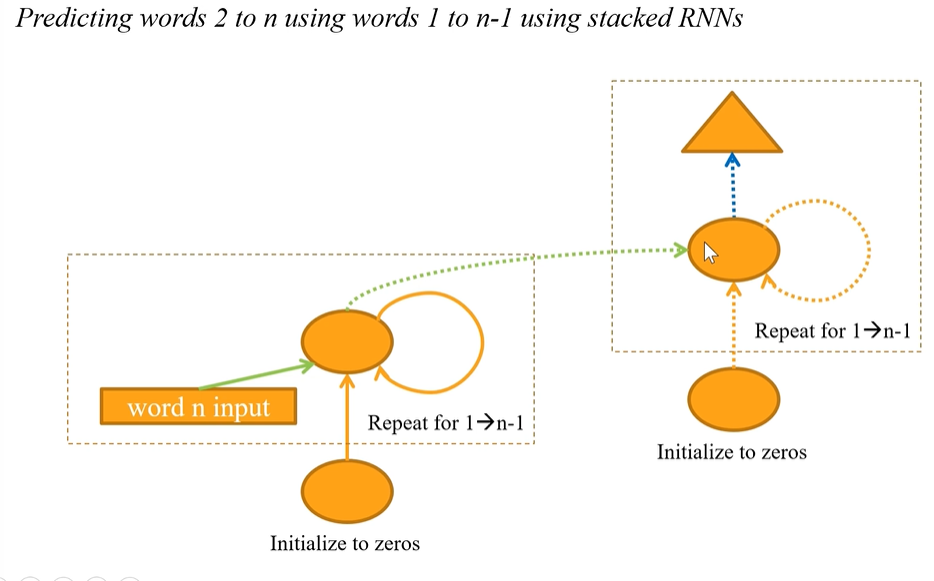

So we have an RNN going into an RNN and that's nice since we have more computation layers. We would expect that to give us a better result.

So what we will do first is do some small refactoring, we will take the forward code and replace it with the equivalent pytorch code which does that *nn.RNN*

In [98]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [101]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [ ]:
learn = Learner(data, Model4(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(20, 3e-3)

So that was just refactoring, now let's add a new layer of rnn which is denoted in the GRU parameter *2*. Bu there's the thing, when we think about a 2 layer RNN without the loop it basically looks like this:

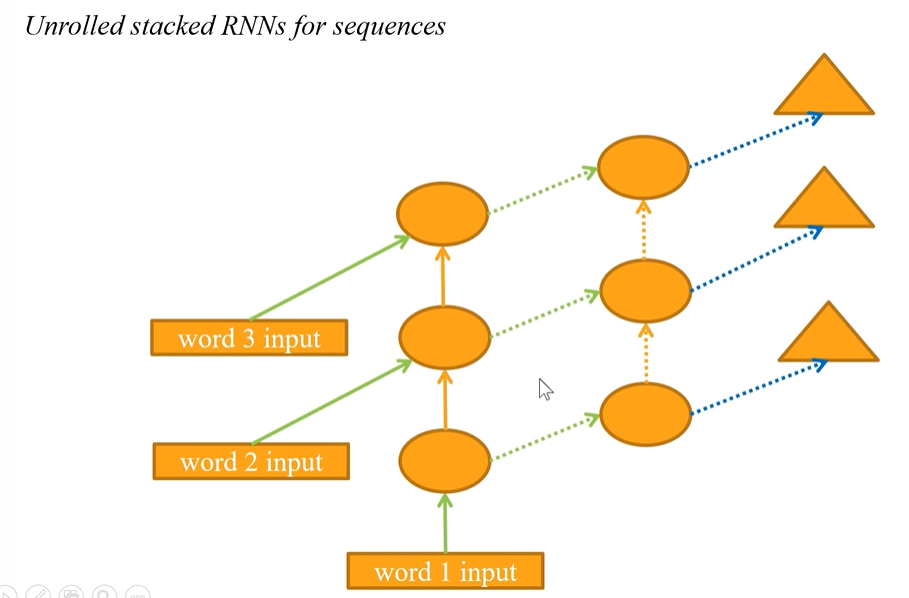

However since our bppt is 20 there are not 3 but 20 hidden layers. And we know from the visualizing the loss landscapes paper that deep networks have awful bumpy surfaces so as we create long timescales with multiple layers this NN start getting impossible to train so there's a few things we can do such as **skip connections** but what people normally do is instead of adding the embeddings of 2 words they usa mini neural net to decide how much of the green arrow to keep and how much of the orange arrow to keep and when we do that we get a **GRU** which we are using or an LSTM depending on the details of the NN.

In [ ]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(2, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [ ]:
learn.fit_one_cycle(10, 1e-2)

Now we are getting much better results than in the last one.